BERT tutorial
https://mccormickml.com/2019/07/22/BERT-fine-tuning/

GAP preprocessing example
https://www.kaggle.com/code/sunilcube/text-data-gendered-pronoun-resolution

Transformer Explanation: https://nlp.seas.harvard.edu/2018/04/03/attention.html http://nlp.seas.harvard.edu/annotated-transformer/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import string
import re
from collections import Counter
import random
from typing import *
import csv

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Display the entire text
pd.set_option("display.max_colwidth", None)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train_path = "../../model/data/train.tsv"
valid_path = "../../model/data/dev.tsv"

In [4]:
def read_dataset(path: str) -> List[Dict]:
    samples: List[Dict] = []
    pron_counter = Counter()
    with open(path) as f:
        next(f)
        for line in f:
            (
                id,
                text,
                pron,
                p_offset,
                entity_A,
                offset_A,
                is_coref_A,
                entity_B,
                offset_B,
                is_coref_B,
                url,
            ) = line.strip().split("\t")
            pron_counter[pron.lower()] += 1
            samples.append(
                {
                    "id": id,
                    "text": text,
                    "pron": pron,
                    "p_offset": int(p_offset),
                    "entity_A": entity_A,
                    "offset_A": int(offset_A),
                    "is_coref_A": is_coref_A,
                    "entity_B": entity_B,
                    "offset_B": int(offset_B),
                    "is_coref_B": is_coref_B,
                    "url": url,
                }
            )
    print(pron_counter)
    return samples, pron_counter

In [5]:
train_dataset, train_pron_counter = read_dataset(train_path)
valid_dataset, valid_pron_counter = read_dataset(valid_path)

Counter({'his': 904, 'her': 773, 'he': 610, 'she': 555, 'him': 157})
Counter({'her': 140, 'his': 108, 'he': 93, 'she': 87, 'him': 26})


In [6]:
train_dataset[0]

{'id': 'train-1',
 'text': "Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'pron': 'her',
 'p_offset': 274,
 'entity_A': 'Cheryl Cassidy',
 'offset_A': 191,
 'is_coref_A': 'TRUE',
 'entity_B': 'Pauline',
 'offset_B': 207,
 'is_coref_B': 'FALSE',
 'url': 'http://en.wikipedia.org/wiki/List_of_Teachers_(UK_TV_series)_characters'}

In the training dataset there is a slightly bias towards the male pronouns (1671 M vs 1328 F).

In [7]:
train_gender_pron_counter = {
    "F": train_pron_counter['her'] + train_pron_counter['she'],
    "M": train_pron_counter['his'] + train_pron_counter['him'] + train_pron_counter['he']
}
train_gender_pron_counter

{'F': 1328, 'M': 1671}

The validation dataset is perfectly balanced between gender pronouns (227 pronous for both Female and Male).

In [8]:
valid_gender_pron_counter = {
    "F": valid_pron_counter['her'] + valid_pron_counter['she'],
    "M": valid_pron_counter['his'] + valid_pron_counter['him'] + valid_pron_counter['he']
}
valid_gender_pron_counter

{'F': 227, 'M': 227}

In [9]:
def freq_most_common_tokens(dataset_text: List[List[str]], n: int = 20) -> dict:
    """
    Returns
    -------
        The first n common tokens and their frequencies, where the tokens are
        retrieved from the list 'dataset_text'.
        
    Parameters
    ----------
    dataset_text: List[List[str]]
        A list of lists of strings. 
        In this case each nested list is a sentence.
    
    n: int
        Indicates how many tokens to consider.
        If it is a negative number, 
        the function returns the frequencies of all the tokens in the dataset.
    
    """
    # The input is flattened
    tokens = flat_list(dataset_text)  

    # If negative number, return the frequency of all the tokens
    if n <= -1:
        return dict(Counter(tokens).most_common(len(Counter(tokens))))
    else:
        return dict(Counter(tokens).most_common(n))

In [10]:
from matplotlib.pyplot import figure
def plot_freq(frequencies: dict, title: str = "plot"):
    """
    A bar chart with frequency of tokens.
    """
    figure(figsize=(8, 4), dpi=80)

    words = list(frequencies.keys())
    freq = list(frequencies.values())

    plt.bar(range(len(frequencies)), freq, tick_label=words)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

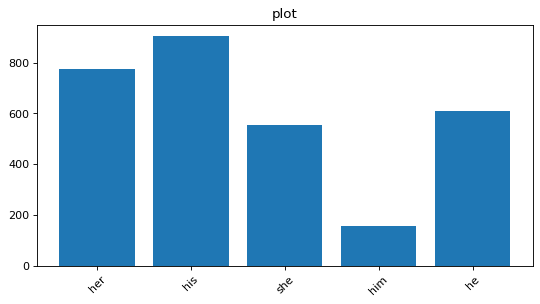

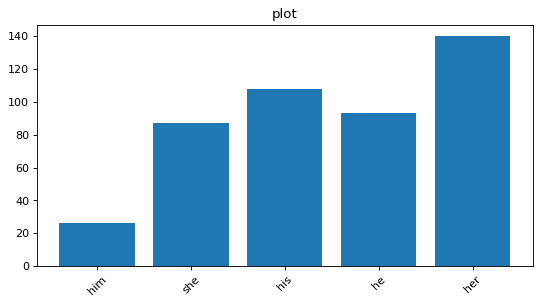

In [11]:
plot_freq(train_pron_counter)
plot_freq(valid_pron_counter)

In [12]:
df_train = pd.DataFrame(train_dataset)
df_valid = pd.DataFrame(valid_dataset)

In [13]:
df_train_entities = df_train[['entity_A', 'is_coref_A', 'entity_B', 'is_coref_B']]
df_train_entities

,entity_A,is_coref_A,entity_B,is_coref_B
0,Cheryl Cassidy,TRUE,Pauline,FALSE
1,MacKenzie,TRUE,Bernard Leach,FALSE
2,Angeloz,FALSE,De la Sota,TRUE
3,Hell,FALSE,Henry Rosenthal,TRUE
4,Kitty Oppenheimer,FALSE,Rivera,TRUE
...,...,...,...,...
2994,Martin,TRUE,Robert Brandon,FALSE
2995,Arthur Davies,TRUE,John Frederick Mowbray-Clarke,FALSE
2996,Katharine Anthony,FALSE,Madge Jenison,FALSE
2997,Carole,TRUE,Lillian Grey,FALSE


In [61]:
# Dataframe contiaining sentences where neither A nor B entities are the right coreference entities to the pronoun
df_train_neither_ent = df_train.loc[(df_train['is_coref_A'] == "FALSE") & (df_train['is_coref_B'] == "FALSE")]

df_train_A_ent = df_train.loc[df_train['is_coref_A'] == "TRUE"]
df_train_B_ent = df_train.loc[df_train['is_coref_B'] == "TRUE"]

print("# sentences:", df_train.shape[0])
print(f"# sentences neither: {df_train_neither_ent.shape[0]} ({((df_train_neither_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")
print(f"# sentences A pronoun: {df_train_A_ent.shape[0]} ({((df_train_A_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")
print(f"# sentences B pronoun: {df_train_B_ent.shape[0]} ({((df_train_B_ent.shape[0] / df_train.shape[0]) * 100):.2f}%)")

# sentences: 2999
# sentences neither: 315 (10.50%)
# sentences A pronoun: 1331 (44.38%)
# sentences B pronoun: 1353 (45.12%)


In [49]:
# Dataframe contiaining sentences where neither A nor B entities are the right coreference entities to the pronoun
df_valid_neither_ent = df_valid.loc[(df_valid['is_coref_A'] == "FALSE") & (df_valid['is_coref_B'] == "FALSE")]

df_valid_A_ent = df_valid.loc[df_valid['is_coref_A'] == "TRUE"]
df_valid_B_ent = df_valid.loc[df_valid['is_coref_B'] == "TRUE"]

print("# sentences:", df_valid.shape[0])
print(f"# sentences neither: {df_valid_neither_ent.shape[0]} ({((df_valid_neither_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")
print(f"# sentences A pronoun: {df_valid_A_ent.shape[0]} ({((df_valid_A_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")
print(f"# sentences B pronoun: {df_valid_B_ent.shape[0]} ({((df_valid_B_ent.shape[0] / df_valid.shape[0]) * 100):.2f}%)")

# sentences: 454
# sentences neither: 62 (13.66%)
# sentences A pronoun: 187 (41.19%)
# sentences B pronoun: 205 (45.15%)


The datasets are pretty balanced with respect the A B pronouns; but we have fewer examples of "neither".

In [18]:
df_train_text_only = df_train['text']
df_train_text_only.sample()

1779    Jeanine Basinger (born 3 February 1936), a film historian, is Corwin-Fuller Professor of Film Studies and Founder and Curator of The Cinema Archives at Wesleyan University, Middletown, Connecticut. She is also a Trustee of the American Film Institute (which awarded her an honorary degree, a Doctorate of Humane Letters, on June 7, 2006 ), a member of the Steering Committee of the National Center for Film and Video Preservation, and one of the Board of Advisors for the Association of Independent Video and Filmmakers.
Name: text, dtype: object

In [75]:
df_train_text_lens = df_train_text_only.map(lambda sentence: len(sentence))

print(f"Mean lenght: {df_train_text_lens.mean():.2f}")
print(f"Min lenght: {df_train_text_lens.min():.2f}")
print(f"Max lenght: {df_train_text_lens.max():.2f}")

Mean lenght: 430.92
Min lenght: 69.00
Max lenght: 1347.00


In [73]:
df_valid_text_only = df_valid['text']
df_valid_text_only.sample()

425    Peter's parish church, Hanwell. George Harris's work can now be much sought-after. In 2006 a late 17th-century lantern clock by George Harris was sold in a Bonhams auction for *12,000. George's third son Nicholas Harris (1657--1738) succeeded to his father's business.
Name: text, dtype: object

In [74]:
df_valid_text_lens = df_valid_text_only.map(lambda sentence: len(sentence))

print(f"Mean lenght: {df_valid_text_lens.mean():.2f}")
print(f"Min lenght: {df_valid_text_lens.min():.2f}")
print(f"Max lenght: {df_valid_text_lens.max():.2f}")

Mean lenght: 426.39
Min lenght: 147.00
Max lenght: 1012.00


In [111]:
df_train_text_lens[df_train_text_lens.map(lambda lenght: lenght == 1347)]

2342    1347
Name: text, dtype: int64

In [115]:
df_train.iloc[2342]

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [117]:
df_train.iloc[2342]['text'][624:626]

'he'

,id,text,pron,p_offset,entity_A,offset_A,is_coref_A,entity_B,offset_B,is_coref_B,url
0,train-1,"Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",her,274,Cheryl Cassidy,191,TRUE,Pauline,207,FALSE,http://en.wikipedia.org/wiki/List_of_Teachers_(UK_TV_series)_characters
1,train-2,"He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.",His,284,MacKenzie,228,TRUE,Bernard Leach,251,FALSE,http://en.wikipedia.org/wiki/Warren_MacKenzie
2,train-3,"He had been reelected to Congress, but resigned in 1990 to accept a post as Ambassador to Brazil. De la Sota again ran for governor of C*rdoba in 1991. Defeated by Governor Angeloz by over 15%, this latter setback was significant because it cost De la Sota much of his support within the Justicialist Party (which was flush with victory in the 1991 mid-terms), leading to President Carlos Menem 's endorsement of a separate party list in C*rdoba for the 1993 mid-term elections, and to De la Sota's failure to regain a seat in Congress.",his,265,Angeloz,173,FALSE,De la Sota,246,TRUE,http://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_de_la_Sota
3,train-4,"The current members of Crime have also performed in San Francisco under the band name ''Remote Viewers``. Strike has published two works of fiction in recent years: Ports of Hell, which is listed in the Rock and Roll Hall of Fame Library, and A Loud Humming Sound Came from Above. Rank has produced numerous films (under his real name, Henry Rosenthal) including the hit The Devil and Daniel Johnston.",his,321,Hell,174,FALSE,Henry Rosenthal,336,TRUE,http://en.wikipedia.org/wiki/Crime_(band)
4,train-5,"Her Santa Fe Opera debut in 2005 was as Nuria in the revised edition of Golijov's Ainadamar. She sang on the subsequent Deutsche Grammophon recording of the opera. For his opera Doctor Atomic, Adams rewrote the role of Kitty Oppenheimer, originally a mezzo-soprano role, for soprano voice, and Rivera sang the rewritten part of Kitty Oppenheimer at Lyric Opera of Chicago, De Nederlandse Opera, and the Metropolitan Opera., all in 2007. She has since sung several parts and roles in John Adams' works, including the soprano part in El Ni*o, and the role of Kumudha in A Flowering Tree in the Peter Sellars production at the New Crowned Hope Festival in Vienna.",She,437,Kitty Oppenheimer,219,FALSE,Rivera,294,TRUE,http://en.wikipedia.org/wiki/Jessica_Rivera
...,...,...,...,...,...,...,...,...,...,...,...
2994,train-2995,"(He is not the same as the Mr. Richard Martin (1570--1618) who was the recorder of London, counsel for the Virginia Company and organizer of The Society of Martin's Hundred, whose subsidiary ``particular plantation'' development circa 1618-1619 was known as Martin's Hundred). Martin commanded the Benjamin under Sir Francis Drake in the 1585--86 expedition to harass the Spanish ports in the New World. On his return, Captain Martin married Mary, daughter of Robert Brandon, a prominent English goldsmith and supplier to Queen Elizabeth I of England.",his,407,Martin,427,TRUE,Robert Brandon,460,FALSE,http://en.wikipedia.org/wiki/John_Martin_(Jamestown)
2995,train-2996,"Feeling guilty, no doubt, for having inherited wealth, she came to deny herself some of the luxuries to which she was accustomed In compensation she collected the latest in